In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/exports/home/jolivieri/equivalence_testing/scripts/')

from equiv_test_funcs import *

In [33]:
def ttests(df):
    
    # run t tests from script (should be what's done in perform tests)

    if norm:
      # normalize each row (sample) by the number of counts
        df = normalize(df)

    if log_scale:
        df = log2_scale(df)

    plot = False

    # testing out function you can use in Python code
    # perform_tests_for_df(df, args.delta)

    out_df = loop_over_genes(df, delta, plot)

    out_df = process_out_df(out_df, delta)
    return out_df["diff_pval_adj"][0], out_df["equiv_pval_adj"][0]

In [57]:
numReads = [5, 10, 50, 100, 500, 1000]

num_trials = 10

num_samples = 3

geneA_fracs = [0.4, 0.6]

norm = True
log_scale = True

delta = 1
alpha = 0.05

In [58]:
np.random.seed(123)

out = {"numReads" : [], "frac_sig_diff" : [], "frac_sig_diff_lower" : [], "frac_sig_diff_upper" : [], 
       "frac_sig_equiv" : [], "frac_sig_equiv_lower" : [], "frac_sig_equiv_upper" : []}

for num in numReads:
    # collect p vals for each
    diff_pvals = []
    equiv_pvals = []
    
    for i in range(num_trials):
        data = {"sample" : [], "A" : [], "B" : [], "cell_type" : []}
        count = 0
        for j in range(len(geneA_fracs)):
            for k in range(num_samples):
                count += 1
                
                # add 1 so it's never zero
                n = np.random.poisson(num) + 1
                A = np.random.binomial(n, geneA_fracs[j])
                data["sample"].append("sample" + str(count))
                data["A"].append(A)
                data["B"].append(n - A)
                data["cell_type"].append(j)
        df = pd.DataFrame(data).set_index("sample")
        
        # get results
        diff_pval, equiv_pval = ttests(df)
        
        # save output
        diff_pvals.append(diff_pval)
        equiv_pvals.append(equiv_pval)
        
        
    # get frac significant
    out["numReads"].append(num)

    num_sig_diff = sum(1 for p in diff_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_sig_diff, num_trials)
    out["frac_sig_diff"].append(num_sig_diff/num_trials)
    out["frac_sig_diff_lower"].append(lower_ci)
    out["frac_sig_diff_upper"].append(upper_ci)

    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_sig_equiv, num_trials)
    out["frac_sig_equiv"].append(num_sig_equiv/num_trials)
    out["frac_sig_equiv_lower"].append(lower_ci)
    out["frac_sig_equiv_upper"].append(upper_ci)
out = pd.DataFrame(out)
display(out)

100%|██████████| 2/2 [00:00<00:00, 378.53it/s]


,numReads,frac_sig_diff,frac_sig_diff_lower,frac_sig_diff_upper,frac_sig_equiv,frac_sig_equiv_lower,frac_sig_equiv_upper
0,5,0.2,0.000000,0.447918,0.3,0.015974,0.584026
1,10,0.2,0.000000,0.447918,0.4,0.096364,0.703636
2,50,0.6,0.296364,0.903636,0.8,0.552082,1.000000
3,100,1.0,1.000000,1.000000,1.0,1.000000,1.000000
4,500,1.0,1.000000,1.000000,1.0,1.000000,1.000000
5,1000,1.0,1.000000,1.000000,1.0,1.000000,1.000000


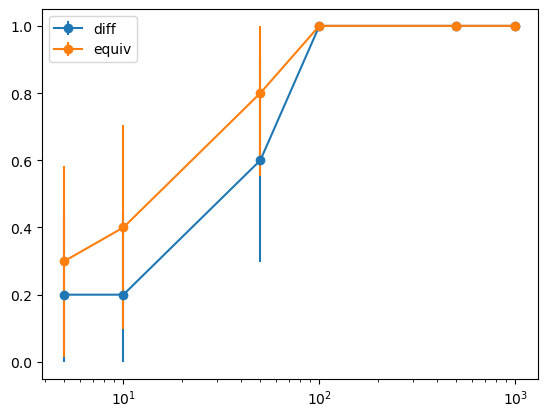

In [59]:
plt.errorbar(out["numReads"], out["frac_sig_diff"], yerr = [out["frac_sig_diff"] - out["frac_sig_diff_lower"],
            out["frac_sig_diff_upper"] - out["frac_sig_diff"] ], marker = "o", label = "diff")
plt.errorbar(out["numReads"], out["frac_sig_equiv"], yerr = [out["frac_sig_equiv"] - out["frac_sig_equiv_lower"],
            out["frac_sig_equiv_upper"] - out["frac_sig_equiv"] ], marker = "o", label = "equiv")
plt.xscale("log")
plt.legend()
plt.show()

In [50]:
out["frac_sig_diff"] - out["frac_sig_diff_lower"]

0    0.200000
1    0.200000
2    0.303636
3    0.000000
4    0.000000
5    0.000000
dtype: float64

In [46]:
df

,A,B,cell_type
sample,,,
sample1,0.373518,0.626482,0
sample2,0.389691,0.610309,0
sample3,0.401020,0.598980,0
sample4,0.585466,0.414534,1
sample5,0.607570,0.392430,1
sample6,0.617676,0.382324,1


In [36]:
plt.errorbar()

,A,B,cell_type
sample,,,
sample1,0.098814,0.901186,0
sample2,0.105210,0.894790,0
sample3,0.091091,0.908909,0
sample4,0.890010,0.109990,1
sample5,0.898185,0.101815,1
sample6,0.899590,0.100410,1


## Method 1 (deprecated)


In [9]:
mean1 = 10
mean2 = 10

var1 = 1
var2 = 1

num_samples = [5, 10, 50, 100, 500, 1000]
num_trials = 10

delta = 0.5

alpha = 0.05

In [29]:
out = {"num_samples" : [], "frac_sig_diff" : [], "frac_sig_equiv" : []}

for n in num_samples:
    
    
    # find fraction significant
    
    # collect p vals for each
    diff_pvals = []
    equiv_pvals = []
    for i in range(num_trials):
        group1 = np.random.normal(loc = mean1, scale = var1, size = n)
        group2 = np.random.normal(loc = mean2, scale = var2, size = n)
        diff_pval, equiv_pval = perform_t_tests(group1, group2, delta)
        diff_pvals.append(diff_pval)
        equiv_pvals.append(equiv_pval)
        
    # correct p vals for each
    # actually, correcting doesn't make sense: we're trying to figure out
    # the indpendent fraction of times it's called as significant
    
    # diff_pval_adj = multipletests(diff_pvals,alpha = alpha, method="fdr_bh")
    # equiv_pval_adj = multipletests(equiv_pvals,alpha = alpha, method="fdr_bh") 
    
    out["num_samples"].append(n)
    out["frac_sig_diff"].append(sum(1 for p in diff_pvals if p < alpha)/num_trials)
    out["frac_sig_equiv"].append(sum(1 for p in equiv_pvals if p < alpha)/num_trials)
    
    # standard deviation doesn't make sense at this point: if we did multiple trials then it would

out = pd.DataFrame(out)

In [30]:
out

,num_samples,frac_sig_diff,frac_sig_equiv
0,5,0.0,0.0
1,10,0.0,0.0
2,50,0.1,0.9
3,100,0.0,1.0
4,500,0.1,1.0
5,1000,0.0,1.0


In [15]:
diff_pval_adj[1]

array([0.73736959, 0.75973327, 0.73736959, 0.73736959, 0.73736959,
       0.73736959, 0.73736959, 0.73736959, 0.73736959, 0.73736959])

In [17]:
equiv_pval_adj[1]

array([3.05708246e-24, 1.60719886e-22, 1.62380870e-22, 5.55766937e-25,
       8.63616044e-22, 1.34527277e-25, 1.02683793e-22, 3.71324687e-21,
       6.03982507e-23, 6.86120588e-25])

In [19]:
equiv_pvals

[1.2228329833663422e-24,
 1.1250391985795497e-22,
 1.2990469578378263e-22,
 1.1115338745794663e-25,
 7.772544395681945e-22,
 1.3452727740817103e-26,
 6.161027558823692e-23,
 3.713246870996315e-21,
 3.019912534759611e-23,
 2.058361764968542e-25]

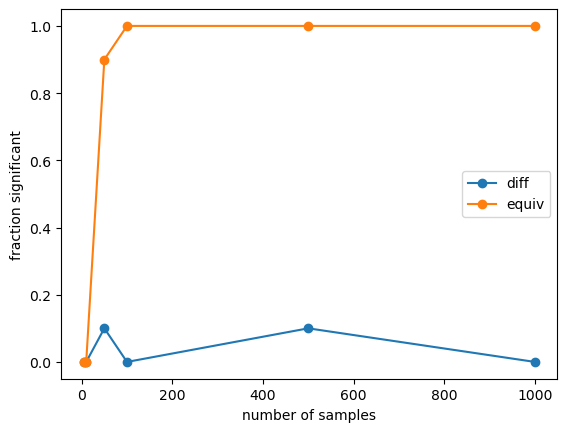

In [33]:
plt.plot(out["num_samples"], out["frac_sig_diff"], label = "diff", marker = "o")
plt.plot(out["num_samples"], out["frac_sig_equiv"], label = "equiv", marker = "o")
plt.legend()
plt.xlabel("number of samples")
plt.ylabel("fraction significant")
plt.show()